# CART Decision Trees (15 marks)

In [3]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.pipeline import make_pipeline
import sklearn.tree as tree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import graphviz
from scipy.stats import norm, zscore
from sklearn.preprocessing import StandardScaler
from model_utils import learning_curves, preprocess_housing
from dtreeviz import trees

In [4]:
california_housing = fetch_california_housing(as_frame=True)
x = california_housing.data
print(x.shape)
y = california_housing.target
print(y.shape)
feature_names = california_housing.feature_names

(20640, 8)
(20640,)


In [5]:
X, y = preprocess_housing(x,y)
X_train, X_test, y_train, y_test = train_test_split(X, y)

data has no null values
Removed 846 outlier rows
Target value counts: 5.00001    965
Name: MedHouseVal, dtype: int64
Removed 670 skewed rows


Training set accuracy: 1.0
Test set accuracy: 0.5591621648970699


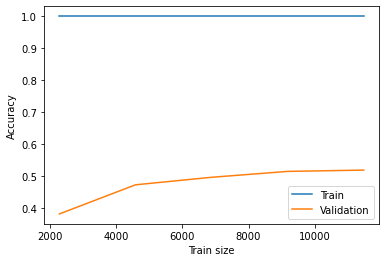

In [6]:
# Apply a decision tree regressor to the California housing dataset

tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)
t1 = tree.score(X_train, y_train)
t2 = tree.score(X_test, y_test)
print("Training set accuracy:", t1)
print("Test set accuracy:", t2)

learning_curves(tree, X_train, y_train)

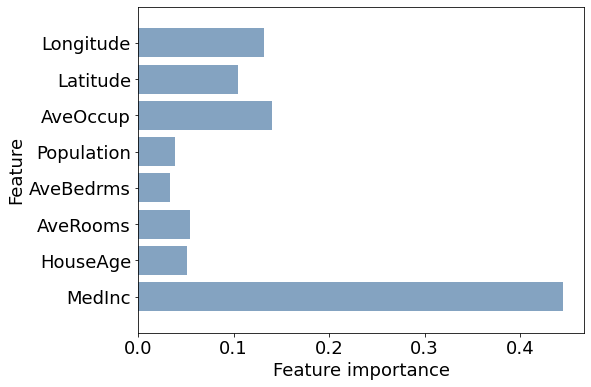

In [27]:
# Plot the influence of each feature on output

def feature_importance(model):
 plt.figure(figsize=(8,6))
 n_features = 8
 plt.barh(range(n_features), model.feature_importances_, align='center', color=(0.2, 0.4, 0.6, 0.6))
 plt.yticks(np.arange(n_features), feature_names)
 plt.xlabel('Feature importance')
 plt.ylabel('Feature')
 plt.ylim(-1, n_features)
feature_importance(tree)
plt.plot('feature_importance')

best score : -0.34431329013942114
best params : {'decisiontreeregressor__max_depth': 9, 'decisiontreeregressor__max_features': 5}
Training set accuracy: 0.7499888638017004
Test set accuracy: 0.5995989336286479


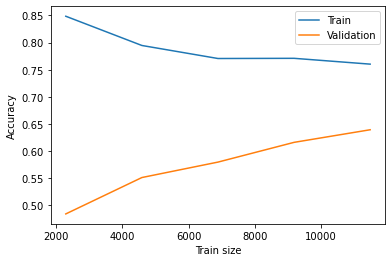

In [52]:
# Use a grid search to tune max depth and max features hyperparameters

def GridSearchCV_(mod, param_grid, X_train, y_train):
    grid = GridSearchCV(estimator=mod, param_grid=param_grid, cv= 5, scoring='neg_mean_squared_error')
    grid.fit(X_train, y_train)
    best_params = grid.best_estimator_
    print('Score :', grid.best_score_ )
    print('Params :', grid.best_params_ )
    return best_params

tree_pipeline = make_pipeline(DecisionTreeRegressor())
param_grid = {'decisiontreeregressor__max_depth':np.arange(5, 30, 1), 
              'decisiontreeregressor__max_features':np.arange(5, 8, 1)               
             }

tuned_tree = GridSearchCV_(tree_pipeline, param_grid , X_train, y_train)
t1 = tuned_tree.score(X_train, y_train)
t2 = tuned_tree.score(X_test, y_test)    
print("Training set accuracy:", t1)
print("Test set accuracy:", t2)

# Plot learning curves for model after parameter tuning
learning_curves(tuned_tree, X_train, y_train)

Text(0, 0.5, 'accuracy')

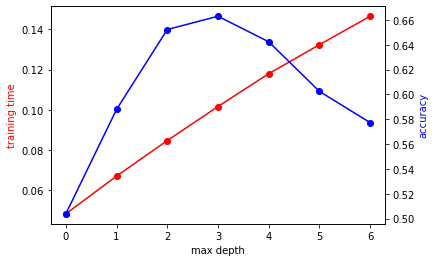

In [10]:
# Plot training times and accuracies for max depth values

times = []
max_depths = [4,6,8,10,12,14,16]
train_accuracies = []
test_accuracies = []
for max_depth in max_depths:
    tree = DecisionTreeRegressor(max_depth=max_depth)
    start = time.time()
    tree.fit(X_train, y_train)
    end = time.time()
    times.append(end-start)
    t1 = tree.score(X_train, y_train)
    t2 = tree.score(X_test, y_test)
    train_accuracies.append(t1)
    test_accuracies.append(t2)

plt.rcParams.update({'font.size': 10})

x = range(len(max_depths))
fig,ax = plt.subplots()
ax.plot(x, times, color="red", marker="o")
ax.set_xlabel("max depth")
ax.set_ylabel("training time", color="red")
ax2 = ax.twinx()
ax2.plot(x, test_accuracies, color="blue", marker="o")
ax2.set_ylabel("accuracy", color="blue")

Text(0, 0.5, 'accuracy')

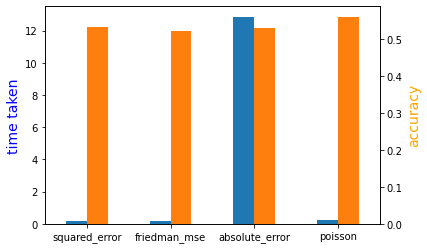

In [12]:
# Plot training times and accuracies for criterions

criterions = ["squared_error", "friedman_mse", "absolute_error", "poisson"]
times = []
train_accuracies = []
test_accuracies = []
for criterion in criterions:
    tree = DecisionTreeRegressor(criterion = criterion)
    start = time.time()
    tree.fit(X_train, y_train)
    end = time.time()
    times.append(end-start)
    t1 = tree.score(X_train, y_train)
    t2 = tree.score(X_test, y_test)
    train_accuracies.append(t1)
    test_accuracies.append(t2)

    
X = ["squaredError", "friedmanMSE", "absoluteError", "poisson"]
X_axis = np.arange(len(X))

df = pd.DataFrame({'time taken': times, 'accuracy': test_accuracies}, index=criterions)
ax = df.plot(kind='bar', secondary_y='accuracy', rot=0, legend=False)
ax.set_ylabel('time taken', fontsize=14, color="blue")
ax.right_ax.set_ylabel('accuracy', fontsize=14, color="orange")


In [21]:
# Visualise the optimised tree

opt_tree = DecisionTreeRegressor(random_state=0, max_depth=8, max_features=6)
opt_tree.fit(X_train, y_train)
t1 = opt_tree.score(X_train, y_train)
t2 = opt_tree.score(X_test, y_test)

print("Training set accuracy:", t1)
print("Test set accuracy:", t2)

dot_data = tree.export_graphviz(opt_tree, out_file=None, feature_names=feature_names, class_names=y_train, filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)
graph.render(directory='decision_tree')
#display(graph)


Training set accuracy: 0.7181457605167875
Test set accuracy: 0.6220913845222631


'decision_tree/Source.gv.pdf'

In [22]:
# Find a point from the test set which misclassifies

predictions = opt_tree.predict(X_test)
diff = 0
true_val = 0
prediction = 0
index = 0
for i in range(len(predictions)):
    curr_diff = abs(y_test.to_numpy()[i] - predictions[i])
    if curr_diff > diff:
        diff = curr_diff
        true_val = y_test.to_numpy()[i]
        prediction = predictions[i]
        index = i

print("Misclassified point", index, "with true value", true_val, "to be", prediction, "with diff", diff)
print(X_test.iloc[4630])
print(y_test.iloc[4630])

Misclassified point 4630 with true value 0.713 to be 4.75 with diff 4.037
MedInc       -0.837196
HouseAge     -0.222082
AveRooms      0.653094
AveBedrms    -0.504282
Population   -1.645409
AveOccup     -1.500219
Latitude      0.101900
Longitude    -0.274693
Name: 3256, dtype: float64
0.713


In [1]:
viz = trees.dtreeviz(opt_tree,
               X_test, 
               y_test, 
               orientation ='LR',  # left-right orientation
               feature_names=feature_names,
               X=X_test.iloc[4630], 
               show_just_path=True)  # Single observation for prediction
              
viz.view()

NameError: name 'trees' is not defined

In [27]:
viz.save('tree-path.svg')

# Ensemble Methods (10 marks) (I've chosen to use AdaBoost)

In [133]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

In [135]:
ada_model = AdaBoostRegressor(opt_tree, random_state=0, n_estimators=100)
ada_model.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=8,
                                                       max_features=6,
                                                       random_state=0),
                  n_estimators=100, random_state=0)

0.8235286709741005
0.7576002622016478


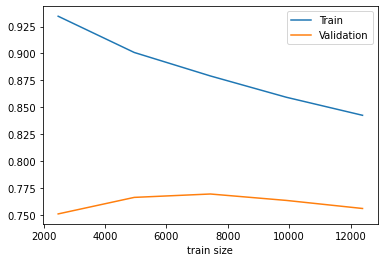

In [119]:
learning_curves(ada_model, X_train, y_train)
print(ada_model.score(X_train, y_train))
print(ada_model.score(X_test, y_test))

Text(0, 0.5, 'accuracy')

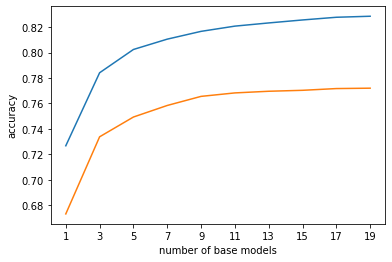

In [141]:
# Investigating effect of changing number of base models

num_models = [1,3,5,7,9,11,13,15,17,19]
train_accuracies = []
test_accuracies = []
for models in num_models:
    ada_model = AdaBoostRegressor(opt_tree, random_state=0, n_estimators=models)
    ada_model.fit(X_train, y_train)
    train_accuracy = ada_model.score(X_train, y_train)
    test_accuracy = ada_model.score(X_test, y_test)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
x = range(len(num_models))
plt.plot(x, train_accuracies)
plt.plot(x, test_accuracies)

plt.xticks(x, num_models)
plt.xlabel('number of base models')
plt.ylabel('accuracy')